In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

fpt = pd.read_csv('/content/drive/MyDrive/Stock_analysis/FPT.csv')
fpt.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97406 entries, 0 to 97405
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ticker         97406 non-null  object 
 1   Date/Time      97406 non-null  object 
 2   Open           97406 non-null  float64
 3   High           97406 non-null  float64
 4   Low            97406 non-null  float64
 5   Close          97406 non-null  float64
 6   Volume         97406 non-null  int64  
 7   Open Interest  97406 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 5.9+ MB


In [ ]:
# Đổi tên cột Date/Time thành Date dễ thao tác
fpt.rename(columns={
    'Date/Time':'Date',
}, inplace=True)

In [ ]:
# Đổi kiểu datetime
fpt['Date'] = pd.to_datetime(fpt['Date'])

# Đặt cột 'Date' làm chỉ số của DataFrame
fpt.set_index('Date', inplace = True)

# Thay đổi dữ liệu theo 15 phút '15T', giờ 'H', ngày 'D'
fpt = fpt.resample('15T').agg({
    'High': 'max',  # Lấy giá trị cao nhất
    'Low': 'min',   # Lấy giá trị thấp nhất
    'Open': 'first', # Lấy giá trị mở cửa đầu tiên
    'Close': 'last', # Lấy giá trị đóng cửa cuối cùng
    'Volume': 'sum'  # Tính tổng khối lượng giao dịch
}).dropna()

In [ ]:
fpt.head()

,High,Low,Open,Close,Volume
Date,,,,,
2018-12-25 09:15:00,30.89,30.59,30.89,30.66,84960
2018-12-26 09:15:00,31.22,31.04,31.04,31.22,13670
2018-12-26 09:30:00,31.11,30.89,31.11,30.96,22420
2018-12-26 09:45:00,31.19,30.89,30.89,31.11,13860
2018-12-26 10:00:00,31.19,31.11,31.19,31.11,36720


In [ ]:
fpt.describe()

,High,Low,Open,Close,Volume
count,8012.000000,8012.000000,8012.000000,8012.000000,8.012000e+03
mean,44.479978,44.299799,44.390357,44.392977,9.779714e+04
std,6.763114,6.727135,6.745880,6.744900,1.096750e+05
min,30.290000,30.220000,30.290000,30.250000,1.000000e+01
25%,38.360000,38.157500,38.280000,38.270000,3.630750e+04
50%,46.650000,46.450000,46.550000,46.550000,6.746000e+04
75%,49.170000,48.910000,49.080000,49.050000,1.204650e+05
max,58.500000,58.100000,58.100000,58.200000,1.920350e+06


<Axes: >

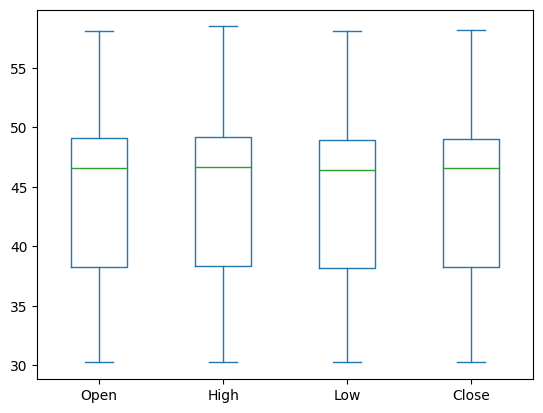

In [ ]:
fpt[['Open', 'High', 'Low', 'Close']].plot(kind ='box')

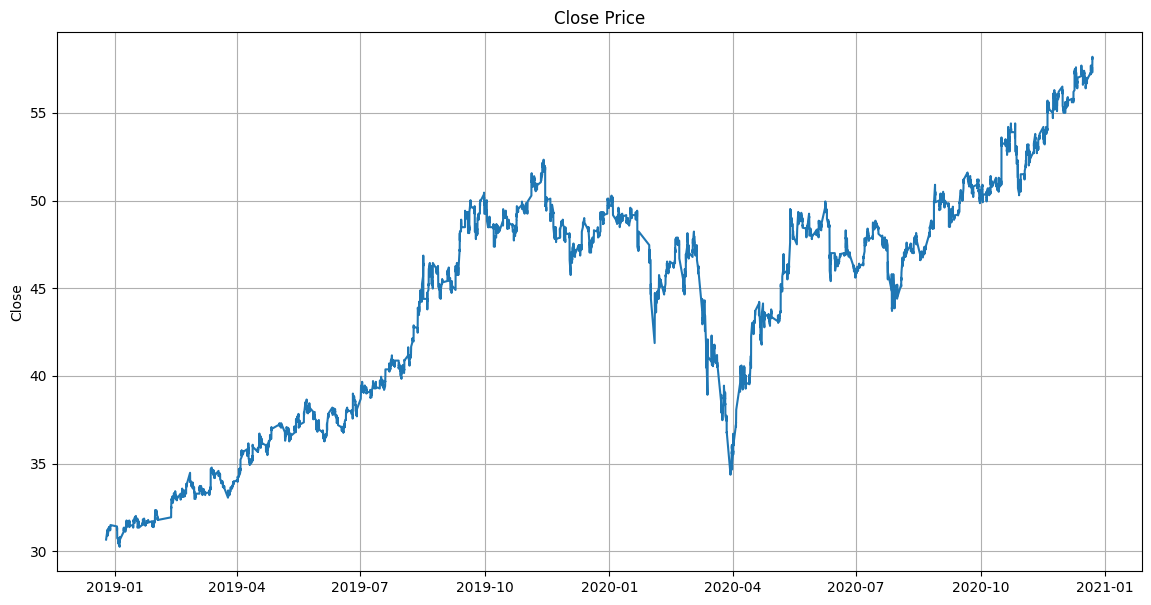

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(fpt['Close'])
plt.ylabel('Close')
plt.title("Close Price")
plt.grid()

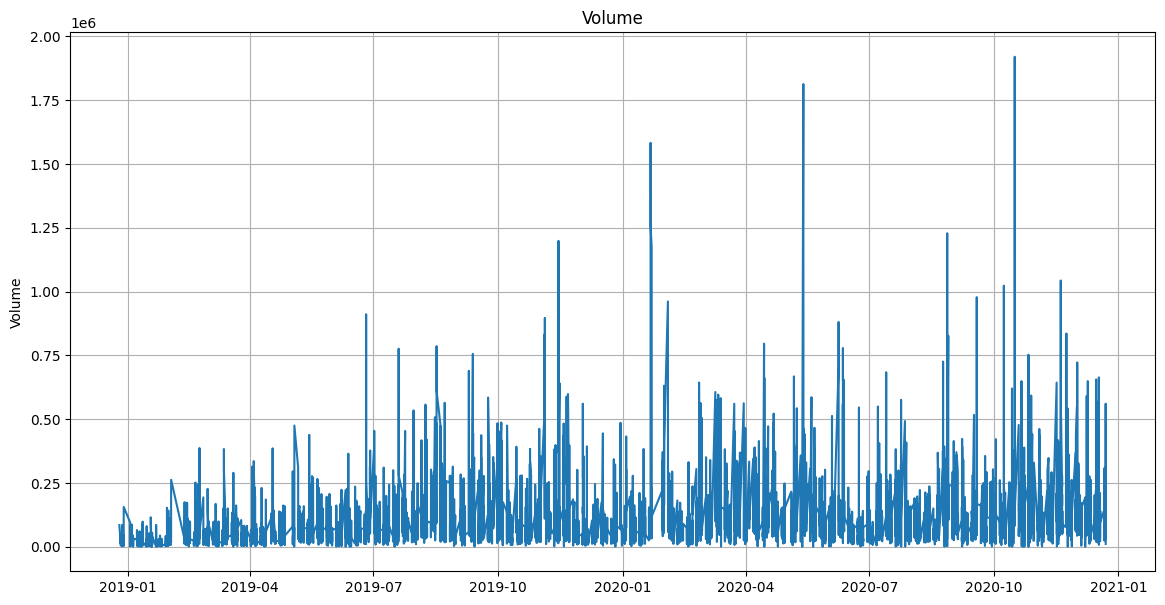

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(fpt['Volume'])
plt.ylabel('Volume')
plt.title("Volume")
plt.grid()

In [ ]:
# Tính biến động giá = giá đóng cửa sau - giá đóng cửa trước
fpt['PriceChange'] = fpt['Close'].shift(-1) - fpt['Close']
fpt.dropna(inplace=True)
fpt.head()

,High,Low,Open,Close,Volume,PriceChange
Date,,,,,,
2018-12-25 09:15:00,30.89,30.59,30.89,30.66,84960,0.56
2018-12-26 09:15:00,31.22,31.04,31.04,31.22,13670,-0.26
2018-12-26 09:30:00,31.11,30.89,31.11,30.96,22420,0.15
2018-12-26 09:45:00,31.19,30.89,30.89,31.11,13860,0.00
2018-12-26 10:00:00,31.19,31.11,31.19,31.11,36720,0.00


**RandomForest**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Chọn các đặc trưng và target
predictors = ['Close', 'Open', 'High', 'Low', 'Volume']
X = fpt[predictors]
y = fpt['PriceChange']

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Huấn luyện model RandomForest
model = RandomForestRegressor(n_estimators=100, min_samples_split=10, random_state=1)
model.fit(X_train, y_train)

# Dự đoán
y_pred = model.predict(X_test)


In [ ]:
# Đánh giá mô hình
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'MSE: {mse}')
print(f'MAE: {mae}')

MSE: 0.0433880457623211
MAE: 0.12186342855145718


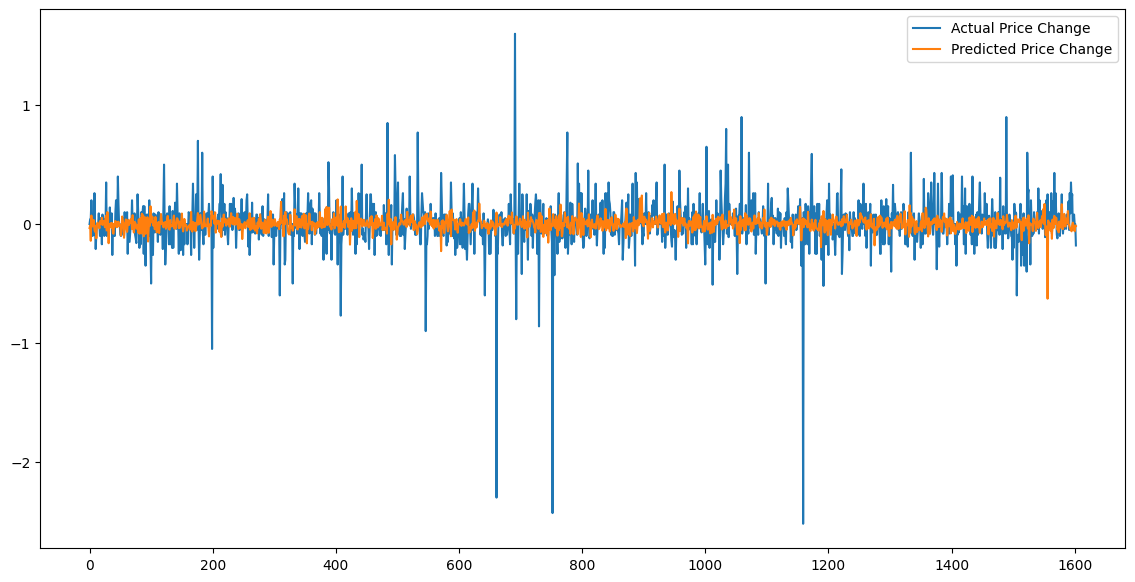

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual Price Change')
plt.plot(y_pred, label='Predicted Price Change')
plt.legend()
plt.show()

**2 LSTM**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Chọn các đặc trưng và target
predictors = ['Close', 'Open', 'High', 'Low', 'Volume']
X = fpt[predictors].values
y = fpt['PriceChange'].values

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Chia dữ liệu thành tập huấn luyện / kiểm tra
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Định dạng lại dữ liệu để phù hợp LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6408, 1, 5) (6408,)
(1603, 1, 5) (1603,)


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Xây dựng mô hình LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(1, X_train.shape[2])))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.fit(X_train, y_train, epochs=50, batch_size=32,  verbose=2)

Epoch 1/50
201/201 - 5s - loss: 0.0348 - 5s/epoch - 24ms/step
Epoch 2/50
201/201 - 1s - loss: 0.0348 - 761ms/epoch - 4ms/step
Epoch 3/50
201/201 - 1s - loss: 0.0347 - 728ms/epoch - 4ms/step
Epoch 4/50
201/201 - 1s - loss: 0.0347 - 734ms/epoch - 4ms/step
Epoch 5/50
201/201 - 1s - loss: 0.0347 - 718ms/epoch - 4ms/step
Epoch 6/50
201/201 - 1s - loss: 0.0348 - 726ms/epoch - 4ms/step
Epoch 7/50
201/201 - 1s - loss: 0.0347 - 891ms/epoch - 4ms/step
Epoch 8/50
201/201 - 1s - loss: 0.0347 - 1s/epoch - 5ms/step
Epoch 9/50
201/201 - 1s - loss: 0.0347 - 1s/epoch - 5ms/step
Epoch 10/50
201/201 - 1s - loss: 0.0347 - 1s/epoch - 6ms/step
Epoch 11/50
201/201 - 1s - loss: 0.0347 - 1s/epoch - 6ms/step
Epoch 12/50
201/201 - 1s - loss: 0.0347 - 672ms/epoch - 3ms/step
Epoch 13/50
201/201 - 1s - loss: 0.0347 - 711ms/epoch - 4ms/step
Epoch 14/50
201/201 - 1s - loss: 0.0347 - 688ms/epoch - 3ms/step
Epoch 15/50
201/201 - 1s - loss: 0.0347 - 705ms/epoch - 4ms/step
Epoch 16/50
201/201 - 1s - loss: 0.0347 - 736ms/

51/51 [==============================] - 1s 2ms/step
LSTM MSE: 0.032962469010589406
LSTM MAE: 0.1147027890335336


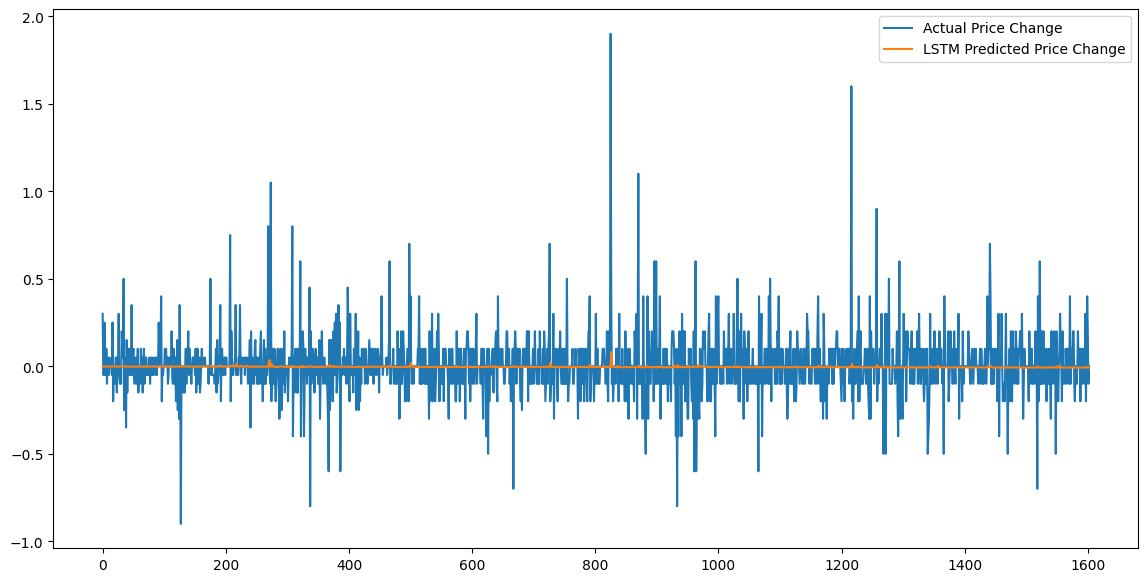

In [ ]:
# Dự đoán với mô hình LSTM
y_pred_lstm = lstm_model.predict(X_test)
y_pred_lstm = y_pred_lstm.flatten()

mse_lstm = mean_squared_error(y_test, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)

print(f'LSTM MSE: {mse_lstm}')
print(f'LSTM MAE: {mae_lstm}')

# Vẽ biểu đồ so sánh giá trị thực và giá trị dự đoán của LSTM
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual Price Change')
plt.plot(y_pred_lstm, label='LSTM Predicted Price Change')
plt.legend()
plt.show()

**GradientBoostingRegressor, MLPRegressor, SVR, xgboost**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# Chọn các đặc trưng và target
predictors = ['Close', 'Open', 'High', 'Low', 'Volume']
X = fpt[predictors]
y = fpt['PriceChange']

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Chia dữ liệu thành tập huấn luyện/ kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'XGBoost':  XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3),
    'SVR': SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1),
    'MLP': MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500, activation='relu', solver='adam')
}

# Train and evaluate models
results = {}

for model_name, model in models.items():
    # Train
    model.fit(X_train, y_train)

    # Dự đoán
    predicted_test = model.predict(X_test)

    # Đánh giá
    mse_test = mean_squared_error(y_test, predicted_test)

    results[model_name] = {
        'test_mse': mse_test,
        'predicted_test': predicted_test
    }

    print(f"{model_name} Test MSE: {mse_test}")

XGBoost Test MSE: 0.03190836528590538
GradientBoosting Test MSE: 0.02903060756888462
SVR Test MSE: 0.028256974550213323
MLP Test MSE: 0.02879535519633175


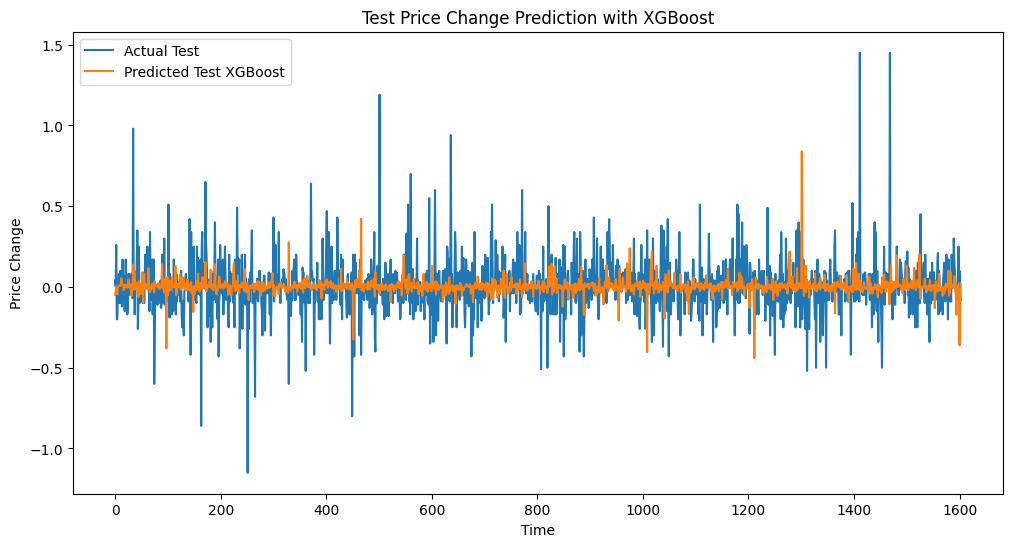

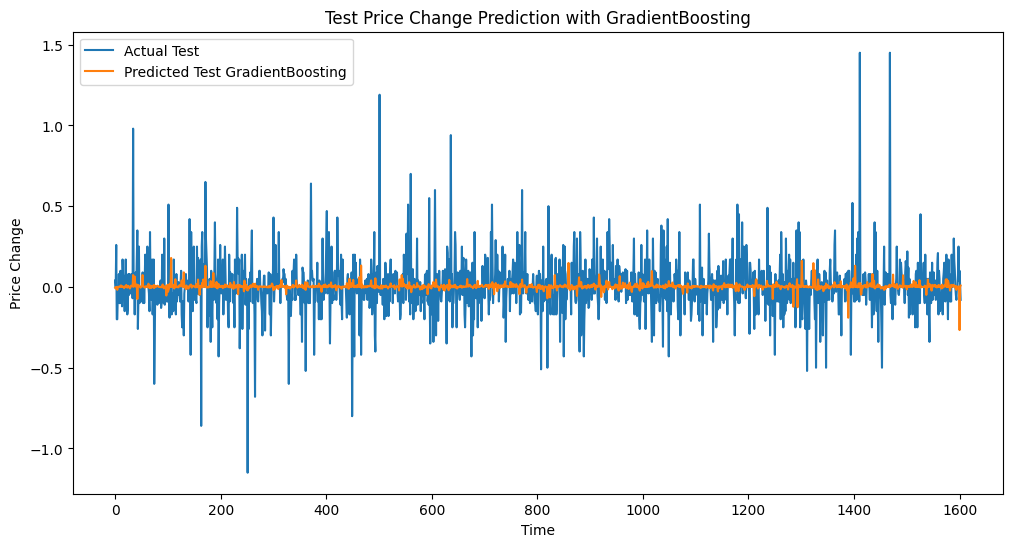

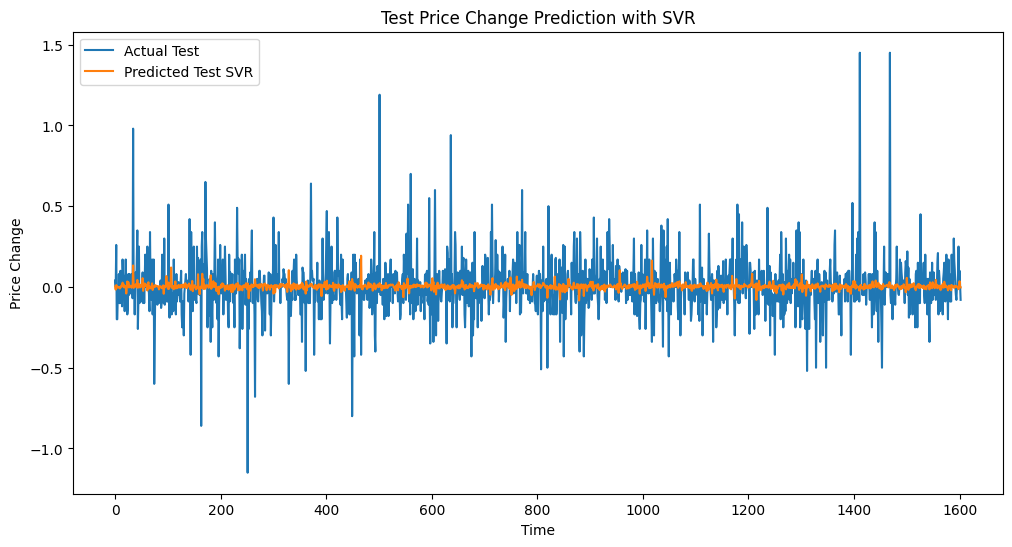

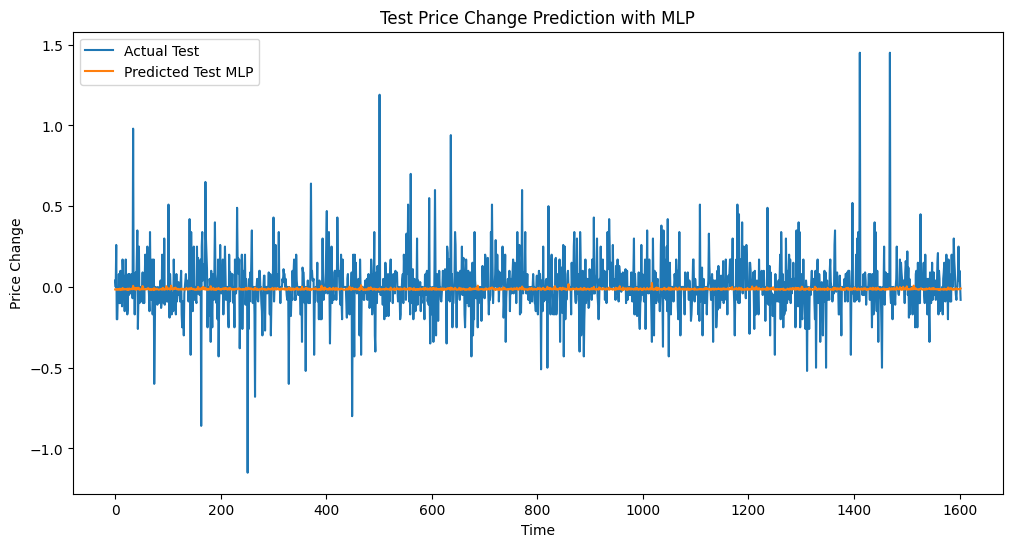

In [ ]:
for model_name, result in results.items():
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.reset_index(drop=True), label='Actual Test')
    plt.plot(result['predicted_test'], label=f'Predicted Test {model_name}')
    plt.title(f'Test Price Change Prediction with {model_name}')
    plt.xlabel('Time')
    plt.ylabel('Price Change')
    plt.legend()
    plt.show()

In [ ]:
import joblib
import os

# Lưu mô hình
model_path = os.path.join('/content/drive/MyDrive/Stock_analysis/model_trained', '15m_SVR_model.pkl')

# mse SVR = 0.2825 thấp nhất
joblib.dump(SVR, model_path)

# Load mô hình từ tệp
# loaded_model = joblib.load('SVR_model.pkl')

['/content/drive/MyDrive/Stock_analysis/model_trained/15m_SVR_model.pkl']